# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [3]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('E:/DTSET/pydata', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('E:/DTSET/pydata', train=False,
                             download=True, transform=transform)

N_train = len(train_data)
indices = list(range(N_train))

np.random.shuffle(indices)

N_valid = int(np.floor(valid_size * N_train))

train_idx, valid_idx = indices[N_valid:], indices[:N_valid]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=valid_sampler, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image - NCHW (channel first) -- NHWC (channel last)

In [19]:
# obtain one batch of training images
dataiter = iter(train_loader)

In [20]:
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

In [21]:
train_loader.batch_size

20

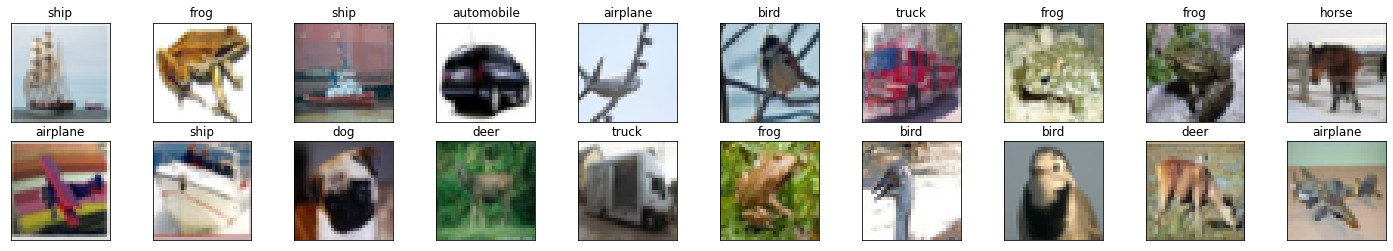

In [22]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)   # 16 filters with size 3x3 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 32 filters with size 3x3
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)                # kernel_size = (2, 2), stride = (2, 2)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)  

        x = F.relu(self.fc1(x))

        x = self.dropout(x) 
        
        x = self.fc2(x)
        
        return x


model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In addition to the model definition, you need to specify loss function and optimizer. Note that if you are refering to the existing implementation, the value  for **learning rate** is important because it determines how your model converges to a small error.

In [12]:
import torch.optim as optim

# categorical cross-entropy loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [13]:
n_epochs = 30

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        
        output = model(data) # feed forward pass
        
        loss = criterion(output, target)
        
        loss.backward() # backward pass
        
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        
        loss = criterion(output, target)
         
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.105282 	Validation Loss: 1.820586
Validation loss decreased (inf --> 1.820586).  Saving model ...
Epoch: 2 	Training Loss: 1.694529 	Validation Loss: 1.500810
Validation loss decreased (1.820586 --> 1.500810).  Saving model ...
Epoch: 3 	Training Loss: 1.497435 	Validation Loss: 1.406608
Validation loss decreased (1.500810 --> 1.406608).  Saving model ...
Epoch: 4 	Training Loss: 1.380584 	Validation Loss: 1.276908
Validation loss decreased (1.406608 --> 1.276908).  Saving model ...
Epoch: 5 	Training Loss: 1.280582 	Validation Loss: 1.204405
Validation loss decreased (1.276908 --> 1.204405).  Saving model ...
Epoch: 6 	Training Loss: 1.189616 	Validation Loss: 1.113476
Validation loss decreased (1.204405 --> 1.113476).  Saving model ...
Epoch: 7 	Training Loss: 1.117511 	Validation Loss: 1.057638
Validation loss decreased (1.113476 --> 1.057638).  Saving model ...
Epoch: 8 	Training Loss: 1.054531 	Validation Loss: 0.995711
Validation loss decreased (1.05763

###  Load the Model with the Lowest Validation Loss

In [14]:
model.load_state_dict(torch.load('model_cifar.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

---
## Test the Trained Network

Test your trained model on previously unseen data! 

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [15]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.714132

Test Accuracy of airplane: 77% (779/1000)
Test Accuracy of automobile: 84% (844/1000)
Test Accuracy of  bird: 67% (675/1000)
Test Accuracy of   cat: 50% (508/1000)
Test Accuracy of  deer: 71% (715/1000)
Test Accuracy of   dog: 73% (732/1000)
Test Accuracy of  frog: 84% (843/1000)
Test Accuracy of horse: 77% (774/1000)
Test Accuracy of  ship: 87% (873/1000)
Test Accuracy of truck: 79% (796/1000)

Test Accuracy (Overall): 75% (7539/10000)


### Question: What are your model's weaknesses and how might they be improved?

#### Visualize Sample Test Results

In [28]:
dataiter = iter(test_loader)

500
20


C:\Users\ashkan\Anaconda3\envs\py36torch11\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


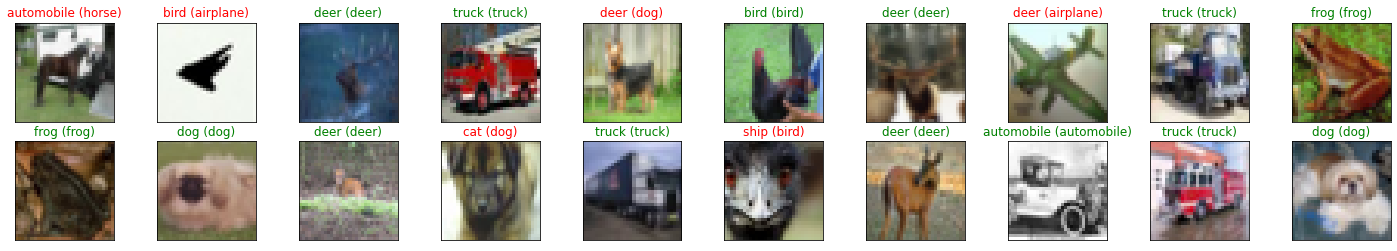

In [30]:
# obtain one batch of test images
images, labels = dataiter.next()
images.numpy()

print(len(test_loader))
print(len(images))

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

**Answer**: This model seems to do best on vehicles rather than animals. For example, it does best on the automobile class and worst on the cat class. I suspect it's because animals vary in color and size and so it would improve this model if I could increase the number of animal images in the first place or perhaps if I added another convolutional layer to detect finer patterns in these images. I could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.